In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
from tqdm import tqdm

import numpy as np
import copy
import json

USE_CUDA = True

In [2]:
def readfile(data):
    with open(data, "r", encoding="utf-8") as f:
        content = f.read().splitlines()
        
    return content

def schema_load(schema_root):
    raw_dict = "".join(readfile(schema_root))
    dict2json = "".join(raw_dict.split()[2:])

    json_acceptable_string = dict2json.replace("'", "\"")
    schema = json.loads(json_acceptable_string)
    
    return schema

def define_entity(schema):
    tag_type = list(schema['tagging'])
    
    entity_tag = []
    for k in list(schema['entity'].keys()):
        entity_tag.append(schema['entity'][k]['tag'])
        
    TAG = []
    for t in tag_type:
        for e in entity_tag:
            if t!='O':
                TAG.append(t+'-'+e)  
                
    TAG = [UNKOWN_TAG, PAD_TAG] + TAG + ['O']   

    return TAG

def tag2ix(TAG):
    tag_to_ix={t:i for i,t in enumerate(TAG)}
    return tag_to_ix

def define_relation(schema):
    relation_type = list(schema['relation'])
    
    relation_tag = []
    for k in list(schema['relation'].keys()):
        relation_tag.append(schema['relation'][k]['tag'])
    
    relation_tag = [REL_PAD] + [REL_NONE] + relation_tag
        
    return relation_tag

# ==================================================

def get_word_and_label(_content, start_w, end_w):
    word_list = []
    ent_list = []
    rel_list = []
    
    for word_set in _content[start_w:end_w]:
        word_set = word_set.split()
        if len(word_set)==1:
            word_list.append(' ')
            ent_list.append('O')
            rel_list.append(REL_NONE)
        
        else:
            word_list.append(word_set[0])
            ent_list.append(word_set[1])

            try:
                testerror = word_set[2]
            except IndexError:
                rel_list.append(REL_NONE)
            else:
                rel_list.append(word_set[2:])
    
    return word_list, ent_list, rel_list

def split_to_list(content):
    init = 0
    word_list = []
    ent_list = []
    rel_list = []

    for now_token, c in enumerate(content):
        if c=='':
            words, ents, rels = get_word_and_label(content, init, now_token)
            init = now_token+1
            word_list.append(words)
            ent_list.append(ents)
            rel_list.append(rels)
            
    return word_list, ent_list, rel_list

# ==================================================

def word2index(word_list):
    word_to_ix = {"<UNKNOWN>":0, "<PAD>":1}
    for sentence in word_list:
        for word in sentence:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
                
    return word_to_ix

def dict_inverse(tag_to_ix):
    ix_to_tag = {v: k for k, v in tag_to_ix.items()}
    return ix_to_tag

def index2tag(indexs, ix_to):
    to_tags = [ix_to[i] for i in indexs.cpu().numpy()]
    return to_tags

# ==================================================

def find_max_len(word_list):
    max_len = 0
    for i in range(len(word_list)):
        if max_len<len(word_list[i]):
            max_len=len(word_list[i])
            
    return max_len

# ====== filter the length of sentence more than MAX_LEN =======

def filter_len(word_list):
    reserved_index = []
    for i in range(len(word_list)):
        if len(word_list[i])<MAX_LEN:
            reserved_index.append(i)
            
    return reserved_index


def filter_sentence(reserved_index, word_list, ent_list, rel_list):
    filter_word = list(word_list[i] for i in reserved_index)
    filter_ent = list(ent_list[i] for i in reserved_index)
    filter_rel = list(rel_list[i] for i in reserved_index)
    return filter_word, filter_ent, filter_rel

# ==================================================

def pad_seq(seq, isrel):
    if isrel:
        seq += [REL_NONE for i in range(MAX_LEN-len(seq))]
    else:
        seq += [PAD_TAG for i in range(MAX_LEN-len(seq))]
    return seq

def pad_all(filter_word, filter_ent, filter_rel):
    input_padded = [pad_seq(s, False) for s in filter_word]
    ent_padded = [pad_seq(s, False) for s in filter_ent]
    rel_padded = [pad_seq(s, True) for s in filter_rel]
    
    return input_padded, ent_padded, rel_padded

def deep_copy_lists(filter_word, filter_ent, filter_rel):
    f_w = copy.deepcopy(filter_word)
    f_e = copy.deepcopy(filter_ent)
    f_r = copy.deepcopy(filter_rel)
    
    return f_w, f_e, f_r

# ==================================================

def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w not in to_ix:
            idxs.append(to_ix[UNKOWN_TAG])
        else:
            idxs.append(to_ix[w])
    
#     idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

def prepare_all(seqs, to_ix):
    seq_list = []
    for i in range(len(seqs)):
        seq_list.append(prepare_sequence(seqs[i], to_ix))
        
    seq_list = torch.stack(seq_list)
        
    return seq_list



def prepare_rel(rel_padded, to_ix):
    
    rel_ptr = torch.zeros(len(rel_padded), MAX_LEN, MAX_LEN, dtype=torch.long) 
    
    # 對當前的token，去比較之前所有出現過的entity，是否有關係，建成矩陣
    # [B*ML*ML]，第二維ML是當前token，第三維ML是根據當前token對之前出現過的entity紀錄關係，以index紀錄
    for i, rel_seq in enumerate(rel_padded):
        rel_dict = {}
        for j, token_seq in enumerate(rel_seq):
            rel_ptr[i][j][:j+1] = 1
            if token_seq != REL_NONE:
                for k, rel in enumerate(token_seq):

                    # if 是第一次出現，紀錄後面數字(標第幾對)和關係位置(A OR B)
                    # 假如下次出現又是同個關係位置(A)，依然紀錄
                    # 直到下次出現關係位置B，依照之前紀錄的A位置的字，然後在第三維去標關係

                    rel_token = rel.split('-')
                    if rel_token[1] not in rel_dict:
                        rel_dict[rel_token[1]] = {'rel':rel_token[0], 'loc':rel_token[2], 'idx':[j]}

                    elif rel_token[1] in rel_dict and rel_dict[rel_token[1]]['loc']==rel_token[2]:
                        rel_dict[rel_token[1]]['idx'].append(j)

                    else:
                        record_loc = rel_dict[rel_token[1]]['idx']
                        for idxx in record_loc:
                            rel_ptr[i][j][idxx] = to_ix[rel_token[0]]
                            
    return rel_ptr
                


# ==================================================

def dataload(input_var, ent_var, rel_var, raw_input):
    torch_dataset = Data.TensorDataset(input_var, ent_var, rel_var, raw_input)

    loader = Data.DataLoader(
        dataset=torch_dataset,      # torch TensorDataset format
        batch_size=BATCH_SIZE,      # mini batch size
        shuffle=True,               
        num_workers=2,       
#         drop_last=True
    )
    
    return loader

# ==================================================
def softmax_entity(entity):
    entity = entity.view(BATCH_SIZE,ent_size).argmax(1)
    return entity

In [3]:
class Attn(nn.Module):
    def __init__(self, attn_input, attn_output, rel_size):
        super(Attn, self).__init__()
        
        self.attn_input = attn_input
        self.attn_output = attn_output
        self.rel_size = rel_size
        
        self.w1 = nn.Linear(self.attn_input, self.attn_output)
        self.w2 = nn.Linear(self.attn_input, self.attn_output)
        self.tanh = nn.Tanh()
        self.v = nn.Linear(self.attn_output, self.rel_size, bias=False)
        self.softmax = nn.LogSoftmax(dim=2)
        
        
    def forward(self, encoder_outputs):
        
        decoder = encoder_outputs[:,-1,:].unsqueeze(1)                       #B*1*(ts+LE) [128,1,8]
        encoder_score = self.w1(encoder_outputs)                             #B*now len*ATTN_OUT
        decoder_score = self.w2(decoder)                                     #B*1*ATTN_OUT
        energy = self.tanh(encoder_score+decoder_score)                      #B*now len*ATTN_OUT            
        
        energy = self.v(energy)                                              #B*now len*rel_size
        
        
        # 針對每個entity做softmax，去顯示他們的關係權重
        # 主要都會是rel_none
        # 對第二維(rel)做softmax
        p = self.softmax(energy)                                         #B*now len*rel_size
        
        return p
    

In [4]:
class Entity_Typing(nn.Module):
    def __init__(self, vocab_size, ent_tag_to_ix, embedding_dim, hidden_dim1, hidden_dim2, \
                 label_embed_dim, rel_tag_to_ix):
        
        super(Entity_Typing, self).__init__()
        self.embedding_dim = embedding_dim                   #E
        self.hidden_dim1 = hidden_dim1                       #h1
        self.hidden_dim2 = hidden_dim2                       #h2
        self.label_embed_dim = label_embed_dim               #LE
        self.vocab_size = vocab_size                         #vs
        self.ent_to_ix = ent_tag_to_ix
        self.ent_size = len(ent_tag_to_ix)                   #es
        self.rel_to_ix = rel_tag_to_ix
        self.rel_size = len(rel_tag_to_ix)                   #rs           
        
        self.dropout = nn.Dropout(p=0.3)
        self.bn = nn.BatchNorm1d(hidden_dim1, momentum=0.5, affine=False)
        
        
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        
#         self.bilstm = nn.LSTM(embedding_dim, hidden_dim1 // 2,
#                             num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)        
        self.bilstm = nn.GRU(embedding_dim, hidden_dim1 // 2,
                            num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)
        
        
        self.dense = nn.Linear(hidden_dim1, DENSE_OUT)
        self.top_hidden = nn.LSTMCell(DENSE_OUT+label_embed_dim, hidden_dim2)          
        

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim2, self.ent_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.label_embed = nn.Linear(self.ent_size, self.label_embed_dim)
        
        self.attn = Attn(ATTN_IN, ATTN_OUT, self.rel_size)
        
        
    def init_hidden1(self):       
        hidden = torch.randn(2*2, self.batch, self.hidden_dim1 // 2)    #4*B*(h1/2)

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_hidden2(self):       
        hidden = torch.randn(self.batch, self.hidden_dim2)              #B*h2

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_label_embed(self):
        hidden = torch.zeros(self.batch, self.label_embed_dim)          #B*LE
        return hidden.cuda()if USE_CUDA else hidden
    
    def create_entity(self):
        output_tensor = torch.zeros(self.batch, MAX_LEN, self.ent_size)  #B*ML*es
        return output_tensor.cuda()if USE_CUDA else output_tensor
    
    def create_rel_matrix(self):
        rel_tensor = torch.zeros(self.batch, MAX_LEN, MAX_LEN, self.rel_size)  #B*ML*ML*rs
        return rel_tensor.cuda()if USE_CUDA else rel_tensor
    
    
        
    def forward(self, sentence, batch_ent, isTrain=True):
        
        self.batch = sentence.size(0)
#         self.hidden1 = self.init_hidden1()                      #4*B*(h1/2)
        entity_tensor = self.create_entity()                    #B*ML*es
        rel_tensor = self.create_rel_matrix()                   #B*ML*ML*rs
        
        

        embeds = self.word_embeds(sentence)                     #B*ML*E,[128, 100, 20]
        
#         bilstm_out, self.hidden1 = self.bilstm(embeds, self.hidden1)
        bilstm_out, hidden1 = self.bilstm(embeds)
        # bilstm_out -> B*ML*h1,[128, 100, 10]
        # self.hidden1 -> ( 4*B*(h1/2), 4*B*(h1/2) )
        
        bilstm_out = torch.transpose(bilstm_out, 1, 2)
        # bn
        bilstm_out = self.bn(bilstm_out)
        bilstm_out = torch.transpose(bilstm_out, 1, 2)
        dense_out = self.dense(bilstm_out)                      #B*ML*DENSE_OUT,[128, 100, 100]
        
        
        encoder_sequence_l = [] 

        for length in range(MAX_LEN):
            now_token = dense_out[:,length,:]
            now_token = torch.squeeze(now_token, 1)
            
            if length==0:
                self.hidden2 = self.init_hidden2()
                self.zero_label_embed = self.init_label_embed()
                combine_x = torch.cat((now_token, self.zero_label_embed),1)  #B*(DENSE_OUT+LE),[128, 103]
                
            else:
                self.hidden2 = (h_next, c_next)
                combine_x = torch.cat((now_token, label),1)

            h_next, c_next = self.top_hidden(combine_x, self.hidden2)    #B*h2,[128, 8]           
            to_tags = self.hidden2tag(h_next)                            #B*es,[128, 5]            
            ent_output = self.softmax(to_tags)                               #B*es,[128, 5]  
            s_ent_output = self.softmax_entity(ent_output)
            ent_onehot = self.one_hot(s_ent_output)
            
            
            if isTrain:
                label = self.label_embed(ent_onehot)                             #B*LE,[128, 3]
#                 label = self.label_embed(ent_output) 
            else:
                batch_ent_onehot = self.one_hot(batch_ent[:,length])
                label = self.label_embed(batch_ent_onehot)
            
     
            
            # Assignments to Variables are in-place operations.
            # Use that variable in lots of other contexts 
            # and some of the functions require it to not change. 
            to_tags_clone = to_tags.clone()
            label_clone = label.clone()
            
            
#             for i, tag in enumerate(s_ent_output):
#                 if tag==ent_tag_to_ix['O']:
#                     to_tags_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
#                     label_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
                    
            # relation layer
#             encoder_sequence_l.append(torch.cat((to_tags,label),1)) 
            encoder_sequence_l.append(torch.cat((h_next,label),1))  
            encoder_sequence = torch.stack(encoder_sequence_l).t()     #B*len*(es+LE), [128,1,8]          

            # Calculate attention weights 
            attn_weights = self.attn(encoder_sequence)

        
            entity_tensor[:,length,:] = ent_output
            
            # rel_tensor[:,length, 頭~當前 ,:]
            rel_tensor[:,length,:length+1,:] = attn_weights

        
        
        '''NLLLoss input: Input: (N,C) where C = number of classes'''
        return entity_tensor.view(self.batch*MAX_LEN, self.ent_size), \
               rel_tensor.view(self.batch*MAX_LEN*MAX_LEN, self.rel_size)
        
        
    def softmax_entity(self, entity):
        entity = entity.view(self.batch,ent_size).argmax(1)
        return entity
    
    
    def one_hot(self, batch_ent):   
        batchsize = batch_ent.size(0)
        nb_digits = len(ent_tag_to_ix)
        batch_ent = torch.unsqueeze(batch_ent, 1)
        y_onehot = torch.cuda.FloatTensor(batchsize, nb_digits)        
        y_onehot.zero_()
        y_onehot.scatter_(1, batch_ent, 1)    

        return y_onehot

In [5]:
root = '/notebooks/sinica/dataset/'
train_data = root+'facial.train'
dev_data = root+'facial.dev'
test_data = root+'facial.test'

relation_data_old = root+'facial_r.old.train'
# relation_data = root+'facial_r.train'
relation_data = root+'facial_r2.train'
schema_root = root+'schema_2.txt'
dev_data = root+'facial_r2.dev'
test_data = root+'facial_r2.test'


UNKOWN_TAG = "<UNKNOWN>"
PAD_TAG = "<PAD>"
REL_NONE = 'Rel-None'
REL_PAD = 'Rel-Pad'
rule = ('FUNC', 'ApplyTo', 'STAT')

schema = schema_load(schema_root)
ENT_TAG = define_entity(schema)
REL_TAG = define_relation(schema)
ent_tag_to_ix = tag2ix(ENT_TAG)
'''{'<PAD>': 1,
 '<UNKNOWN>': 0,
 'B-FUNC': 2,
 'B-STAT': 3,
 'I-FUNC': 4,
 'I-STAT': 5,
 'O': 6}'''
rel_tag_to_ix = tag2ix(REL_TAG)
'''{'ApplyTo': 2, 'Rel-None': 1, 'Rel-Pad': 0}'''

# ========hyper-parameter-set==========

ent_size = len(ent_tag_to_ix)
rel_size = len(rel_tag_to_ix)
MAX_LEN = 100
BATCH_SIZE = 18

EMBEDDING_DIM = 20
HIDDEN_DIM1 = 10
HIDDEN_DIM2 = 8
LABEL_EMBED_DIM = ent_size
DENSE_OUT = 100

# ATTN_IN = ent_size+LABEL_EMBED_DIM
ATTN_IN = HIDDEN_DIM2+LABEL_EMBED_DIM
ATTN_OUT = 6

In [6]:
def preprocess(data):
    content = readfile(data)
    word_list, ent_list, rel_list = split_to_list(content)
    word_to_ix = word2index(word_list)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    #================================================
    vocab_size = len(word_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, vocab_size, word_to_ix, reserved_index, word_list

def dev_preprocess(dev_data):
    dev_content = readfile(dev_data)
    word_list, ent_list, rel_list = split_to_list(dev_content)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, reserved_index, word_list


In [7]:
ix_to_ent_tag = dict_inverse(ent_tag_to_ix)
ix_to_rel_tag = dict_inverse(rel_tag_to_ix)
#===============================================
input_var, ent_var, rel_var, vocab_size, word_to_ix, raw_index, raw_input = preprocess(relation_data)
loader = dataload(input_var, ent_var, rel_var, raw_index)

input_dev, ent_dev, rel_dev, raw_index_dev, raw_input_dev = dev_preprocess(dev_data)
dev_loader = dataload(input_dev, ent_dev, rel_dev, raw_index_dev)

In [8]:
model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
              LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion_tag = nn.NLLLoss(ignore_index=1)
# criterion_rel = nn.NLLLoss(ignore_index=0)
criterion_rel = nn.NLLLoss()

In [9]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
n_iters = 70
print_every = 12

train_entloss_l = []
val_entloss_l = []
train_relloss_l = []
val_relloss_l = []

total_loss = 0 # Reset every plot_every iters
loss = 0
ent_loss = 0

start = time.time()

for epoch in tqdm(range(n_iters)):  
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(loader):
        model.train()
        optimizer.zero_grad()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=True)
        
        batchsize = batch_x.size(0)
        
        batch_ent = batch_ent.view(batchsize*MAX_LEN)
        batch_rel = batch_rel.view(batchsize*MAX_LEN*MAX_LEN)
        
        entloss = criterion_tag(ent_output, batch_ent.cuda() if USE_CUDA else batch_ent)
        relloss = criterion_rel(rel_output, batch_rel.cuda() if USE_CUDA else batch_rel)
        loss = entloss+relloss
        
        loss.backward()
#         loss.backward(retain_graph=True)
        optimizer.step()
        

    train_entloss_l.append(entloss.cpu())
    train_relloss_l.append(relloss.cpu())
    #    print('%.4f| epoch: %d| step: %d| %s' % (loss, epoch, step, timeSince(start)))
        
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=True)
        
        batchsize = batch_x.size(0)
        
        val_entloss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN)) 
        val_relloss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
        
    val_entloss_l.append(val_entloss.cpu())
    val_relloss_l.append(val_relloss.cpu())
    
    
    print("epoch: %d | ent loss %.4f | rel loss %.4f | total loss %.4f" \
          % (epoch+1, entloss, relloss, loss))
    print("      %s  | val ent loss %.4f | val rel loss %.4f"
          % (" "*len(str(epoch+1)), val_entloss, val_relloss))


  1%|▏         | 1/70 [00:07<08:40,  7.54s/it]

epoch: 1 | ent loss 0.7708 | rel loss 0.0776 | total loss 0.8484
         | val ent loss 0.5864 | val rel loss 0.0677


  3%|▎         | 2/70 [00:15<08:35,  7.57s/it]

epoch: 2 | ent loss 0.6118 | rel loss 0.0189 | total loss 0.6307
         | val ent loss 0.6499 | val rel loss 0.0180


  4%|▍         | 3/70 [00:22<08:27,  7.58s/it]

epoch: 3 | ent loss 0.7208 | rel loss 0.0101 | total loss 0.7309
         | val ent loss 0.4734 | val rel loss 0.0099


  6%|▌         | 4/70 [00:30<08:15,  7.51s/it]

epoch: 4 | ent loss 0.6014 | rel loss 0.0091 | total loss 0.6104
         | val ent loss 0.6876 | val rel loss 0.0080


  7%|▋         | 5/70 [00:37<08:06,  7.48s/it]

epoch: 5 | ent loss 0.5976 | rel loss 0.0084 | total loss 0.6060
         | val ent loss 0.5635 | val rel loss 0.0069


  9%|▊         | 6/70 [00:45<08:01,  7.52s/it]

epoch: 6 | ent loss 0.4991 | rel loss 0.0081 | total loss 0.5072
         | val ent loss 0.4853 | val rel loss 0.0059


 10%|█         | 7/70 [00:52<07:56,  7.56s/it]

epoch: 7 | ent loss 0.3185 | rel loss 0.0063 | total loss 0.3248
         | val ent loss 0.3266 | val rel loss 0.0053


 11%|█▏        | 8/70 [01:00<07:50,  7.60s/it]

epoch: 8 | ent loss 0.2842 | rel loss 0.0055 | total loss 0.2898
         | val ent loss 0.2006 | val rel loss 0.0042


 13%|█▎        | 9/70 [01:08<07:44,  7.61s/it]

epoch: 9 | ent loss 0.2894 | rel loss 0.0046 | total loss 0.2941
         | val ent loss 0.2985 | val rel loss 0.0042


 14%|█▍        | 10/70 [01:16<07:38,  7.64s/it]

epoch: 10 | ent loss 0.1900 | rel loss 0.0053 | total loss 0.1953
          | val ent loss 0.2622 | val rel loss 0.0041


 16%|█▌        | 11/70 [01:24<07:32,  7.67s/it]

epoch: 11 | ent loss 0.1701 | rel loss 0.0049 | total loss 0.1750
          | val ent loss 0.2070 | val rel loss 0.0029


 17%|█▋        | 12/70 [01:32<07:25,  7.68s/it]

epoch: 12 | ent loss 0.1456 | rel loss 0.0039 | total loss 0.1496
          | val ent loss 0.1751 | val rel loss 0.0024


 19%|█▊        | 13/70 [01:39<07:18,  7.68s/it]

epoch: 13 | ent loss 0.1069 | rel loss 0.0043 | total loss 0.1112
          | val ent loss 0.1169 | val rel loss 0.0035


 20%|██        | 14/70 [01:48<07:12,  7.72s/it]

epoch: 14 | ent loss 0.1177 | rel loss 0.0035 | total loss 0.1211
          | val ent loss 0.1435 | val rel loss 0.0033


 21%|██▏       | 15/70 [01:55<07:04,  7.72s/it]

epoch: 15 | ent loss 0.0955 | rel loss 0.0041 | total loss 0.0996
          | val ent loss 0.1342 | val rel loss 0.0026


 23%|██▎       | 16/70 [02:03<06:55,  7.70s/it]

epoch: 16 | ent loss 0.0867 | rel loss 0.0031 | total loss 0.0897
          | val ent loss 0.2172 | val rel loss 0.0032


 24%|██▍       | 17/70 [02:11<06:49,  7.72s/it]

epoch: 17 | ent loss 0.0796 | rel loss 0.0032 | total loss 0.0828
          | val ent loss 0.2051 | val rel loss 0.0024


 26%|██▌       | 18/70 [02:19<06:42,  7.74s/it]

epoch: 18 | ent loss 0.0500 | rel loss 0.0027 | total loss 0.0527
          | val ent loss 0.1155 | val rel loss 0.0024


 27%|██▋       | 19/70 [02:26<06:33,  7.71s/it]

epoch: 19 | ent loss 0.0689 | rel loss 0.0032 | total loss 0.0721
          | val ent loss 0.0903 | val rel loss 0.0024


 29%|██▊       | 20/70 [02:33<06:24,  7.69s/it]

epoch: 20 | ent loss 0.0474 | rel loss 0.0028 | total loss 0.0503
          | val ent loss 0.1114 | val rel loss 0.0026


 30%|███       | 21/70 [02:41<06:16,  7.68s/it]

epoch: 21 | ent loss 0.0411 | rel loss 0.0030 | total loss 0.0441
          | val ent loss 0.2050 | val rel loss 0.0020


 31%|███▏      | 22/70 [02:49<06:09,  7.69s/it]

epoch: 22 | ent loss 0.0624 | rel loss 0.0023 | total loss 0.0647
          | val ent loss 0.1088 | val rel loss 0.0023


 33%|███▎      | 23/70 [02:56<06:01,  7.69s/it]

epoch: 23 | ent loss 0.0470 | rel loss 0.0025 | total loss 0.0495
          | val ent loss 0.1584 | val rel loss 0.0024


 34%|███▍      | 24/70 [03:05<05:54,  7.71s/it]

epoch: 24 | ent loss 0.0240 | rel loss 0.0021 | total loss 0.0261
          | val ent loss 0.1881 | val rel loss 0.0018


 36%|███▌      | 25/70 [03:12<05:47,  7.72s/it]

epoch: 25 | ent loss 0.0275 | rel loss 0.0027 | total loss 0.0302
          | val ent loss 0.1137 | val rel loss 0.0019


 37%|███▋      | 26/70 [03:19<05:37,  7.68s/it]

epoch: 26 | ent loss 0.0311 | rel loss 0.0021 | total loss 0.0333
          | val ent loss 0.0817 | val rel loss 0.0018


 39%|███▊      | 27/70 [03:27<05:29,  7.67s/it]

epoch: 27 | ent loss 0.0198 | rel loss 0.0021 | total loss 0.0219
          | val ent loss 0.1463 | val rel loss 0.0022


 40%|████      | 28/70 [03:34<05:22,  7.68s/it]

epoch: 28 | ent loss 0.0139 | rel loss 0.0019 | total loss 0.0158
          | val ent loss 0.0827 | val rel loss 0.0022


 41%|████▏     | 29/70 [03:42<05:14,  7.68s/it]

epoch: 29 | ent loss 0.0440 | rel loss 0.0022 | total loss 0.0462
          | val ent loss 0.1160 | val rel loss 0.0020


 43%|████▎     | 30/70 [03:50<05:07,  7.68s/it]

epoch: 30 | ent loss 0.0288 | rel loss 0.0021 | total loss 0.0309
          | val ent loss 0.0805 | val rel loss 0.0015


 44%|████▍     | 31/70 [03:58<04:59,  7.69s/it]

epoch: 31 | ent loss 0.0215 | rel loss 0.0025 | total loss 0.0239
          | val ent loss 0.0784 | val rel loss 0.0015


 46%|████▌     | 32/70 [04:06<04:52,  7.69s/it]

epoch: 32 | ent loss 0.0216 | rel loss 0.0019 | total loss 0.0235
          | val ent loss 0.1169 | val rel loss 0.0018


 47%|████▋     | 33/70 [04:13<04:44,  7.69s/it]

epoch: 33 | ent loss 0.0161 | rel loss 0.0018 | total loss 0.0179
          | val ent loss 0.1131 | val rel loss 0.0013


 49%|████▊     | 34/70 [04:21<04:37,  7.69s/it]

epoch: 34 | ent loss 0.0082 | rel loss 0.0020 | total loss 0.0101
          | val ent loss 0.1527 | val rel loss 0.0012


 50%|█████     | 35/70 [04:29<04:29,  7.70s/it]

epoch: 35 | ent loss 0.0124 | rel loss 0.0015 | total loss 0.0139
          | val ent loss 0.0732 | val rel loss 0.0014


 51%|█████▏    | 36/70 [04:37<04:21,  7.70s/it]

epoch: 36 | ent loss 0.0117 | rel loss 0.0017 | total loss 0.0134
          | val ent loss 0.1482 | val rel loss 0.0012


 53%|█████▎    | 37/70 [04:45<04:14,  7.71s/it]

epoch: 37 | ent loss 0.0097 | rel loss 0.0016 | total loss 0.0113
          | val ent loss 0.1246 | val rel loss 0.0014


 54%|█████▍    | 38/70 [04:52<04:06,  7.71s/it]

epoch: 38 | ent loss 0.0133 | rel loss 0.0017 | total loss 0.0150
          | val ent loss 0.1339 | val rel loss 0.0012


 56%|█████▌    | 39/70 [05:00<03:58,  7.71s/it]

epoch: 39 | ent loss 0.0097 | rel loss 0.0015 | total loss 0.0111
          | val ent loss 0.1262 | val rel loss 0.0012


 57%|█████▋    | 40/70 [05:08<03:51,  7.71s/it]

epoch: 40 | ent loss 0.0056 | rel loss 0.0016 | total loss 0.0072
          | val ent loss 0.0534 | val rel loss 0.0013


 59%|█████▊    | 41/70 [05:16<03:43,  7.72s/it]

epoch: 41 | ent loss 0.0128 | rel loss 0.0014 | total loss 0.0142
          | val ent loss 0.1989 | val rel loss 0.0015


 60%|██████    | 42/70 [05:24<03:36,  7.73s/it]

epoch: 42 | ent loss 0.0047 | rel loss 0.0014 | total loss 0.0061
          | val ent loss 0.1408 | val rel loss 0.0012


 61%|██████▏   | 43/70 [05:32<03:28,  7.73s/it]

epoch: 43 | ent loss 0.0063 | rel loss 0.0015 | total loss 0.0078
          | val ent loss 0.0594 | val rel loss 0.0014


 63%|██████▎   | 44/70 [05:40<03:21,  7.73s/it]

epoch: 44 | ent loss 0.0044 | rel loss 0.0011 | total loss 0.0056
          | val ent loss 0.1052 | val rel loss 0.0013


 64%|██████▍   | 45/70 [05:48<03:13,  7.74s/it]

epoch: 45 | ent loss 0.0094 | rel loss 0.0014 | total loss 0.0108
          | val ent loss 0.1280 | val rel loss 0.0011


 66%|██████▌   | 46/70 [05:56<03:05,  7.74s/it]

epoch: 46 | ent loss 0.0087 | rel loss 0.0013 | total loss 0.0099
          | val ent loss 0.2097 | val rel loss 0.0016


 67%|██████▋   | 47/70 [06:04<02:58,  7.75s/it]

epoch: 47 | ent loss 0.0072 | rel loss 0.0014 | total loss 0.0086
          | val ent loss 0.1535 | val rel loss 0.0012


 69%|██████▊   | 48/70 [06:11<02:50,  7.74s/it]

epoch: 48 | ent loss 0.0050 | rel loss 0.0013 | total loss 0.0063
          | val ent loss 0.0505 | val rel loss 0.0015


 70%|███████   | 49/70 [06:18<02:42,  7.71s/it]

epoch: 49 | ent loss 0.0046 | rel loss 0.0012 | total loss 0.0058
          | val ent loss 0.1052 | val rel loss 0.0011


 71%|███████▏  | 50/70 [06:25<02:34,  7.70s/it]

epoch: 50 | ent loss 0.0065 | rel loss 0.0017 | total loss 0.0083
          | val ent loss 0.1938 | val rel loss 0.0012


 73%|███████▎  | 51/70 [06:32<02:26,  7.70s/it]

epoch: 51 | ent loss 0.0060 | rel loss 0.0011 | total loss 0.0070
          | val ent loss 0.1149 | val rel loss 0.0011


 74%|███████▍  | 52/70 [06:39<02:18,  7.69s/it]

epoch: 52 | ent loss 0.0038 | rel loss 0.0011 | total loss 0.0049
          | val ent loss 0.1013 | val rel loss 0.0011


 76%|███████▌  | 53/70 [06:47<02:10,  7.69s/it]

epoch: 53 | ent loss 0.0060 | rel loss 0.0011 | total loss 0.0071
          | val ent loss 0.0571 | val rel loss 0.0013


 77%|███████▋  | 54/70 [06:55<02:03,  7.69s/it]

epoch: 54 | ent loss 0.0083 | rel loss 0.0015 | total loss 0.0097
          | val ent loss 0.0881 | val rel loss 0.0012


 79%|███████▊  | 55/70 [07:03<01:55,  7.70s/it]

epoch: 55 | ent loss 0.0064 | rel loss 0.0013 | total loss 0.0077
          | val ent loss 0.1209 | val rel loss 0.0011


 80%|████████  | 56/70 [07:10<01:47,  7.69s/it]

epoch: 56 | ent loss 0.0036 | rel loss 0.0013 | total loss 0.0049
          | val ent loss 0.2838 | val rel loss 0.0013


 81%|████████▏ | 57/70 [07:18<01:39,  7.69s/it]

epoch: 57 | ent loss 0.0064 | rel loss 0.0012 | total loss 0.0076
          | val ent loss 0.1910 | val rel loss 0.0007


 83%|████████▎ | 58/70 [07:25<01:32,  7.68s/it]

epoch: 58 | ent loss 0.0068 | rel loss 0.0015 | total loss 0.0084
          | val ent loss 0.0553 | val rel loss 0.0011


 84%|████████▍ | 59/70 [07:33<01:24,  7.68s/it]

epoch: 59 | ent loss 0.0035 | rel loss 0.0012 | total loss 0.0046
          | val ent loss 0.0510 | val rel loss 0.0011


 86%|████████▌ | 60/70 [07:40<01:16,  7.68s/it]

epoch: 60 | ent loss 0.0082 | rel loss 0.0012 | total loss 0.0094
          | val ent loss 0.1561 | val rel loss 0.0012


 87%|████████▋ | 61/70 [07:48<01:09,  7.68s/it]

epoch: 61 | ent loss 0.0056 | rel loss 0.0011 | total loss 0.0067
          | val ent loss 0.2210 | val rel loss 0.0013


 89%|████████▊ | 62/70 [07:56<01:01,  7.68s/it]

epoch: 62 | ent loss 0.0033 | rel loss 0.0011 | total loss 0.0044
          | val ent loss 0.1695 | val rel loss 0.0011


 90%|█████████ | 63/70 [08:04<00:53,  7.69s/it]

epoch: 63 | ent loss 0.0061 | rel loss 0.0012 | total loss 0.0073
          | val ent loss 0.0927 | val rel loss 0.0012


 91%|█████████▏| 64/70 [08:11<00:46,  7.68s/it]

epoch: 64 | ent loss 0.0032 | rel loss 0.0012 | total loss 0.0044
          | val ent loss 0.1072 | val rel loss 0.0011


 93%|█████████▎| 65/70 [08:19<00:38,  7.68s/it]

epoch: 65 | ent loss 0.0026 | rel loss 0.0012 | total loss 0.0038
          | val ent loss 0.1010 | val rel loss 0.0010


 94%|█████████▍| 66/70 [08:26<00:30,  7.68s/it]

epoch: 66 | ent loss 0.0024 | rel loss 0.0010 | total loss 0.0035
          | val ent loss 0.2066 | val rel loss 0.0009


 96%|█████████▌| 67/70 [08:34<00:23,  7.68s/it]

epoch: 67 | ent loss 0.0047 | rel loss 0.0012 | total loss 0.0059
          | val ent loss 0.1150 | val rel loss 0.0010


 97%|█████████▋| 68/70 [08:41<00:15,  7.68s/it]

epoch: 68 | ent loss 0.0037 | rel loss 0.0011 | total loss 0.0048
          | val ent loss 0.0780 | val rel loss 0.0008


 99%|█████████▊| 69/70 [08:50<00:07,  7.68s/it]

epoch: 69 | ent loss 0.0042 | rel loss 0.0012 | total loss 0.0054
          | val ent loss 0.0922 | val rel loss 0.0009


100%|██████████| 70/70 [08:57<00:00,  7.68s/it]

epoch: 70 | ent loss 0.0052 | rel loss 0.0014 | total loss 0.0066
          | val ent loss 0.1882 | val rel loss 0.0013


In [11]:
# save and load model
torch.save(model.state_dict(), 'relation_extraction_1_new.pkl')

# model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
#               LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
# model.load_state_dict(torch.load('relation_extraction.pkl'))

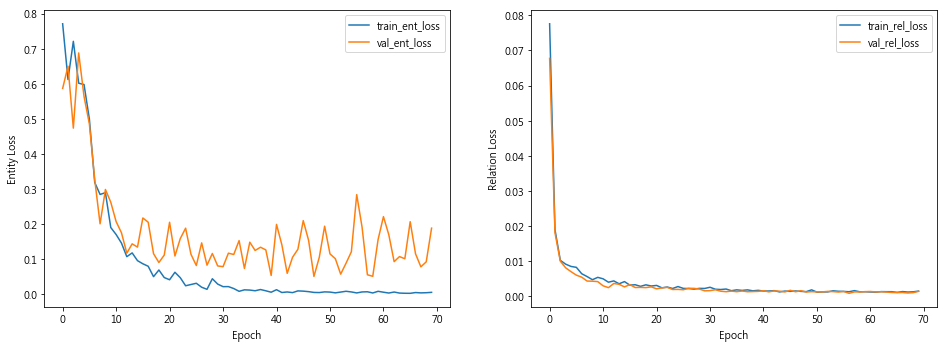

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt


plt.figure(figsize=(16, 12))
plt.subplot(2,2,1)
plt.plot(train_entloss_l, label='train_ent_loss')
plt.plot(val_entloss_l, label='val_ent_loss')
plt.xlabel("Epoch")
plt.ylabel("Entity Loss") 
plt.legend()

plt.subplot(2,2,2)
plt.plot(train_relloss_l, label='train_rel_loss')
plt.plot(val_relloss_l, label='val_rel_loss')
plt.xlabel("Epoch")
plt.ylabel("Relation Loss") 
plt.legend()
plt.show()

In [13]:
import random
def random_choose(input_var):
    r_choose = []
    for i in range(BATCH_SIZE):
        r_choose.append(random.randint(0,len(input_var)))
    return r_choose
        
def ent_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,ent_size).argmax(2)
    return output

def rel_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,MAX_LEN,rel_size).argmax(3)
    return output

In [14]:
# Check predictions after training
with torch.no_grad():
    r_choose = random_choose(input_var)
    model.eval()
    ent_output, rel_output = model(input_var[r_choose].cuda() if USE_CUDA else input_var, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=True)
    
    batchsize = input_var[r_choose].size(0)
    
    ent_loss = criterion_tag(ent_output.cpu(), ent_var[r_choose].view(BATCH_SIZE*MAX_LEN))
    ent_output = ent_argmax(ent_output, batchsize)
    
    rel_loss = criterion_rel(rel_output.cpu(), rel_var[r_choose].view(BATCH_SIZE*MAX_LEN*MAX_LEN))
    
    print()
    print('predict :', index2tag(ent_output[0], ix_to_ent_tag))
    print('true :', index2tag(ent_var[r_choose[0]], ix_to_ent_tag))
    
    print()
    print("Entity loss : %.4f" % ent_loss)
    print("Relation loss : %.4f" % rel_loss)


predict : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
true : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '<PAD>', '<PAD>', '<PAD>', '<PAD>',

In [15]:
import warnings
warnings.filterwarnings('always') 

def evaluate_data(data_loader, raw_input):
    with torch.no_grad():
        for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(data_loader):
            model.eval()
            ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                           if USE_CUDA else batch_ent, isTrain=False)

            batchsize = batch_x.size(0)

            ent_loss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN))
            ent_output = ent_argmax(ent_output, batchsize)

            rel_loss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
            rel_output = rel_argmax(rel_output, batchsize)


            print()    
            print("Entity loss : %.4f" % ent_loss)
            print("Relation loss : %.4f" % rel_loss)
            print()

            batch_decode(ent_output, rel_output, batch_index, raw_input, batch_ent, batch_rel)
            print('===========================================')

            
            
            
def batch_decode(ent_output, rel_output, batch_index, word_lists, true_ent, true_rel):
    
    for e,r,i,te,tr in zip(ent_output, rel_output, batch_index, true_ent, true_rel):
        
        # 算句子長度
        len_of_list = len(word_lists[i])
        word_list = word_lists[i]
        true_ent = index2tag(te, ix_to_ent_tag)[:len_of_list]
        pridict_ent = index2tag(e, ix_to_ent_tag)[:len_of_list]     
        
        # 單句decode關係
        true_r_list, appear_error = decode_rel(te, tr)   # true
        pre_r_list, appear_error = decode_rel(e, r)      # predict
        
        true_r_list = [list(set(i)) if type(i) is list else i for i in true_r_list]
        pre_r_list = [list(set(i)) if type(i) is list else i for i in pre_r_list]
        
        # 出現error，跳過這句
        if appear_error:
            continue
        
        true_r_list = true_r_list[:len_of_list]
        pre_r_list = pre_r_list[:len_of_list]
        
        
        # 評分用
        eval_ent_list_true, err_count = decode_ent(true_ent, schema)
        eval_rel_list_true = decode_rel_to_eval(true_r_list, schema, eval_ent_list_true)
        
        eval_ent_list_pred, err_count = decode_ent(pridict_ent, schema)
        eval_rel_list_pred = decode_rel_to_eval(pre_r_list, schema, eval_ent_list_pred)
        
        print(word_list)
        print(true_ent)
        print(true_r_list)
        print()
        print('Predict output')
        print(pridict_ent)
        print(pre_r_list)
        print()
        print('True')
        print(eval_ent_list_true)
        print(eval_rel_list_true)
        print('predict')
        print(eval_ent_list_pred)
        print(eval_rel_list_pred)
        print("=====================================")
        

        
        
        
        



def decode_ent(pred_ent, schema):
    '''
    Aggregate entities from predicted tags
    Input:
    pred_ent=a list of entity tags in a sentence
    schema=the dictionary defining entities and relations
    Output: 
    ent_list=[(ent_start, ent_end, ent_type=eid_in_schema)]
    err_count=the number of bad tags
    '''
    ent_list = []
    ent_start = 0
    ent_end = 0
    state = {
        'ENT_SPAN': 0,
        'NO_ENT': 1
    }
    err_count = 0
    ent_type = ''
    sid = state['NO_ENT']
    for idx, e_tag in enumerate(pred_ent):
        bio = e_tag[0]
        type_tag = e_tag.split('-')[-1]
        if sid == state['NO_ENT']:
            if bio == 'B':
                ent_start = idx
                ent_type = get_eid_from_tag(type_tag, schema)
                sid = state['ENT_SPAN']
            elif bio == 'I':
                err_count += 1
        elif sid == state['ENT_SPAN']:
            if bio != 'I':
                ent_end = idx - 1
                ent_list.append((ent_start, ent_end, ent_type))
                if bio == 'B':
                    ent_start = idx
                    ent_type = get_eid_from_tag(type_tag, schema)
                else:
                    sid = state['NO_ENT']
            elif ent_type != get_eid_from_tag(type_tag, schema):
                ent_end = idx - 1
                ent_list.append((ent_start, ent_end, ent_type))
                err_count += 1
                sid = state['NO_ENT']
    if sid == state['ENT_SPAN']:
        ent_end = len(pred_ent) - 1
        ent_list.append((ent_start, ent_end, ent_type))
    return ent_list, err_count

def get_eid_from_tag(tag, schema):
    '''
    Assume schema is a dictionary in schema.txt
    return eid or -1 if no match is found
    '''
    for content in schema['entity'].values():
        if content['tag'] == tag:
            return content['eid']
    return -1



def decode_rel_to_eval(r_list, schema, ent_list):
    
    max_pair = 0
    for r in r_list:
        if type(r) is list:
            for single_r in r:
                if int(single_r[-3])>max_pair:
                    max_pair = int(single_r[-3])
    

    pair_idx = {}
    for pair in range(max_pair+1):
        for i, r in enumerate(r_list):
            if type(r) is list:
                for single_r in r:
                    if int(single_r[-3])==pair:
                        if pair not in pair_idx:
                            pair_idx[pair] = [i]
                        else:
                            pair_idx[pair].append(i)
    
    
#     # 算兩兩不同tag的數目
#     e_type_dict = {}
#     for e_pair in ent_list:
#         if e_pair[-1] not in e_type_dict:
#             e_type_dict[e_pair[-1]] = 1
#         else:
#             e_type_dict[e_pair[-1]] += 1
    
#     total_pair = 0
#     e_type_l = list(e_type_dict.values())
#     for i, ent_type_num_1 in enumerate(e_type_l):
#         for j, ent_type_num_2 in enumerate(e_type_l[i+1:]):
#             pair_num = ent_type_num_1*ent_type_num_2
#             total_pair += pair_num

    pair_list = []
    for i, e_pair_1 in enumerate(ent_list):
        for j, e_pair_2 in enumerate(ent_list[i+1:]):
            if e_pair_1[-1]!=e_pair_2[-1]:
                pair_list.append([e_pair_1, e_pair_2])
                
                
    
    
    eval_rel_list = []
    for pair in pair_idx:
        rel_loc = pair_idx[pair]
        for e_pairs in pair_list:
            check_pair = True
            first_start = e_pairs[0][0]
            first_end = e_pairs[0][1]
            sec_start = e_pairs[1][0]
            sec_end = e_pairs[1][1]
            
            first_l = list(range(first_start, first_end+1))
            sec_l = list(range(sec_start, sec_end+1))
            combine_l = first_l+sec_l

            
            check_in_entity = []
            for x in combine_l:
                if x in rel_loc:
                    check_in_entity.append(True)
                else:
                    check_in_entity.append(False)
                    check_pair = False
                    break             

            if all(check_in_entity)==True:
                for r in r_list[first_start]:
                    r_info = r.split('-')
                    
                    if int(r_info[1])==pair:
                        r_tag = get_rid_from_tag(r_info[0], schema)
                        e_pairs_copy = copy.copy(e_pairs)
                        e_pairs_copy.append(r_tag)
                        eval_rel_list.append(e_pairs_copy)
    
    return eval_rel_list
        

        
def get_rid_from_tag(tag, schema):   
    for content in schema['relation'].values():
        if content['tag'] == tag:
            return content['rid']




def create_rel_info(ent_output):
    r_list = []     # 存放完整關係
    r_dict = {}     # 記錄關係資訊
    appear_error = False

    pred_ent = index2tag(ent_output, ix_to_ent_tag)
    

    e_loc = 0       # 當前遇到的entity的位置
    for loc, e in enumerate(pred_ent):
        if e[0]=='B':
            e_loc = loc
            r_dict[loc] = {
                '_2ndtag':e[2:],
                'end':loc,
            }
            r_list.append([])
                   
        elif e[0]=='I':
            # 錯誤來自於，entity預測錯誤，沒有預測到B tag，直接跳到I tag
            # 所以沒有紀錄e_loc
            try: 
                r_dict[e_loc]['end'] = loc
            except KeyError:
                appear_error = True
                break
            
            r_list.append([])
            
        else:
            r_list.append("")
              
    return r_list, r_dict, appear_error
        
        
def decode_rel(ent_output, rel_output):

    r_list, r_dict, appear_error = create_rel_info(ent_output) 
    
    IsB = False           # 是否遇到B tag的lock
    IsNext = False        # 是否為B tag後面的tag 的lock
    num_reocrd = -1       # 紀錄pair數
    now_loc = 0
    pre_rel_end_loc = 0
    now_rel_end_loc = 0
    
    rel_keyerror = False
    
    for now in range(len(rel_output)):
        for loc, rel in enumerate(rel_output[now][:now+1]):
            rel = rel.cpu().numpy()
            
#             print(rel, IsB, IsNext)
            
            # 有關係存在，且為B tag 
            if rel!=rel_tag_to_ix[REL_NONE] and IsB==False and IsNext==False:

                IsB = True
                IsNext = True
                tag = ix_to_rel_tag[int(rel)]
                num_reocrd+=1
                now_loc = loc
                
                # 錯誤來自於，now_loc找不到，也就是說，rel預測出來是有關係存在
                # 但預測是'O'
                # 而在entity中卻沒有預測出來，所以r_dict中沒有紀錄
                try:
                    pre_rel_end_loc = r_dict[now_loc]['end']

                except KeyError:
                    rel_keyerror = True
                    break
                    
                
                try:
                    now_rel_end_loc = r_dict[now]['end']
                    
                except KeyError:
                    rel_keyerror = True
                    break
            
             
                second_tag = r_dict[now_loc]['_2ndtag']
                preAorB = check_rel_loc(second_tag, schema)
                nowAorB = 'B' if preAorB=='A' else 'A'
                
                pre_complete_rel = tag+"-"+str(num_reocrd)+"-"+preAorB
                now_complete_rel = tag+"-"+str(num_reocrd)+"-"+nowAorB
                
                # 將以前的token填上關係
                for token in range(now_loc, pre_rel_end_loc+1):
                    
                    # 出現以下error
                    '''AttributeError: 'str' object has no attribute 'append'''
                    # 為 r_list 前處理中沒有給予可能有關係的位置空的list
                    try:
                        r_list[token].append(pre_complete_rel)
                    except AttributeError:
                        r_list[token] = []
                        r_list[token].append(pre_complete_rel)

             
                # 當前token填上關係
                r_list[now].append(now_complete_rel)
                

            
            # 關係前位中B tag後面的tag
            elif rel!=rel_tag_to_ix[REL_NONE] and IsB:
                # 如果還在這個entity的範圍內
                if loc<=pre_rel_end_loc:
                    pass
                
                # 超出現在這個entity的範圍，改lock
                else:
                    IsB = False

            
            # B tag後面的tag的關係，依照前面的關係複製
            elif rel!=rel_tag_to_ix[REL_NONE] and IsNext:
                r_list[now] = r_list[now-1]
                
                
            else:
                if now<=now_rel_end_loc:
                    IsB = False
                else:
                    IsB = False
                    IsNext = False

        
        if rel_keyerror:
            rel_keyerror = False
            break
                
                
    return r_list, appear_error
                

# 是三元關係中的前者還是後者                  
def check_rel_loc(second_tag, schema):
    convert_tag = ''

    for ent_content in schema['entity']:
        if schema['entity'][ent_content]['tag']==second_tag:
            convert_tag = ent_content
    
    rel_types = schema['relation'].values()

    for rel_content in schema['relation'].values():
        for AorB in rel_content['arguments']:
            if rel_content['arguments'][AorB]==convert_tag:
                return AorB

In [16]:
# 要加 isTrain參數

evaluate_data(dev_loader, raw_input_dev)


Entity loss : 0.1060
Relation loss : 0.0010

['S', 't', 'e', 'p', '2', '.', '強', '化', '補', '水', '-', '嫩', '白', '蠶', '絲', '面', '膜', '-', '面', '膜', '非', '常', '薄', '貼', '，', '記', '得', '要', '把', '蠶', '絲', '面', '膜', '朝', '臉', '敷', '上', '後', '再', '把', '珍', '珠', '膜', '撕', '下', '布', '料', '採', '用', '凝', '水', '蠶', '絲', '，', '清', '透', '，', '用', '天', '然', '草', '本', '植', '物', '萃', '取', '的', '精', '華', '，', '幫', '助', '保', '濕', '，', '也', '可', '以', '舒', '緩', '一', '些', '夏', '季', '保', '養', '時', '乾', '燥', '肌', '的', '狀', '況']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I

['而', '面', '膜', '的', '精', '華', '液', '不', '算', '多', '，', '但', '也', '很', '夠', '用', '了', '，', '是', '敷', '上', '之', '後', '不', '會', '滴', '下', '的', '量', '，', '剛', '剛', '好', '，', '精', '華', '液', '本', '身', '沒', '什', '麼', '香', '味', '，', '我', '這', '個', '小', '敏', '感', '的', '油', '性', '肌', '老', '實', '說', '敷', '完', '之', '後', '卻', '什', '麼', '感', '覺', '都', '沒', '有', '，', '沒', '有', '過', '敏', '、', '沒', '有', '感', '覺', '特', '別', '保', '水', '、', '緊', '緻', '.', '.', '.', '等']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

['極', '效', '肌', '因', '修', '護', '巨', '藻', '、', '齒', '缘', '墨', '角', '藻', '複', '合', '水', '解', '酵', '母', '提', '取', '物', '，', '浸', '透', '濕', '潤', '乾', '燥', '肌', '膚', '，', '增', '強', '防', '護', '屏', '障', '，', '協', '同', '蘆', '薈', '、', '山', '金', '車', '及', '光', '果', '甘', '草', '植', '萃', '精', '華', '，', '深', '度', '安', '撫', '同', '時', '舒', '緩', '肌', '膚', '的', '不', '適', '，', '拋', '開', '惱', '人', '的', '乾', '燥', '缺', '水', '不', '安', '讓', '肌', '膚', '穩', '定']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['我', '覺', '得', '這', '面', '膜', '在', '這', '價', '位', '還', '可', '以', '接', '受', '，', '尤', '其', '是', '很', '會', '過', '敏', '的', '人', '來', '說', '，', '能', '使', '用', '的', '產', '品', '不', '多', '，', '保', '濕', '度', '對', '乾', '性', '肌', '的', '我', '來', '說', '也', '還', '可', '以', '，', '這', '款', '我', '覺', '得', '可', '以', '再', '回', '購']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predic

['高', '效', '保', '濕', '，', '舒', '緩', '肌', '膚', '，', '溫', '和', '修', '復', '，', '重', '塑', '晶', '透', '的', '的', '亮', '顏', '全', '效', '保', '濕', '，', '改', '善', '乾', '性', '肌', '膚', '問', '題', '，', '使', '肌', '膚', '亮', '透', '有', '光', '澤']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O

['露', '珠', '草', '萃', '取', '液', '晶', '華', '能', '舒', '緩', '肌', '膚', '乾', '燥', '不', '適', '並', '加', '強', '保', '濕']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], '', '', '', '', '', ['ApplyTo-1-A'], ['ApplyTo-1-A']]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], '', '', '', '', '', ['ApplyTo-1-A'], ['ApplyTo-1-A']]

True
[(9, 10, 0), (11, 14, 1), (20, 21, 0)]
[[(9, 10, 0), (11, 1

In [17]:
test_data = root+'facial_r2.test'
input_test, ent_test, rel_test, raw_index_test, raw_input_test = dev_preprocess(test_data)
test_loader = dataload(input_test, ent_test, rel_test, raw_index_test)

In [18]:
evaluate_data(test_loader, raw_input_test)


Entity loss : 0.1636
Relation loss : 0.0009

['香', '味', '清', '淡', '，', '使', '用', '起', '來', '很', '水', '潤', '，', '又', '不', '黏', '膩', '，', '比', '一', '般', '保', '濕', '化', '妝', '水', '保', '濕', '，', '卻', '又', '不', '會', '使', '皮', '膚', '出', '油', '，', '很', '好', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['混', '合', '性', '膚', '質', '的', '我', '洗', '完', '很', '保', '濕', '清', '爽', '不', '油', '膩']
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '']

Predict output
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '']

True
[(0, 4, 1), (10, 11, 0)]
[[(0, 4, 1), (10, 11, 0), 0]]
predict
[(0, 4, 1), (10, 11, 0)]
[[(0, 4, 1), (10, 11, 0), 0]]
['舒', '緩', '鎮', '定', '效', '果', '還', '可', '以', '.', '.', '我', '是', '敏', '感', '肌', '.', '.', '第', '一', '次', '用', '時', '兩', '頰', '有', '點', '小', '小', '癢', '.', '.']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 

['看', '了', '一', '下', '商', '品', '說', '明', '，', '了', '解', '這', '項', '產', '品', '主', '要', '訴', '求', '就', '是', '保', '濕', '，', '連', '夏', '天', '在', '冷', '氣', '房', '會', '造', '成', '的', '乾', '燥', '肌', '膚', '也', '很', '適', '合', '使', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

['覺', '得', '這', '款', '面', '膜', '只', '能', '單', '純', '滋', '潤', '乾', '燥', '肌', '膚', '，', '敷', '完', '馬', '上', '感', '覺', '美', '容', '液', '全', '被', '肌', '膚', '吸', '收', '可', '是', '維', '持', '度', '我', '覺', '得', '還', '好', '，', '要', '即', '使', '進', '行', '日', '常', '保', '養', '擦', '乳', '霜', '來', '鎖', '住', '水', '分', '就', '更', '完', '美', '了']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

['整', '體', '來', '說', ',', '這', '款', '面', '膜', '的', '保', '濕', '度', '、', '舒', '緩', '力', '、', '維', '持', '度', '和', '服', '貼', '度', '都', '很', '不', '錯', ',', '不', '過', '面', '膜', '的', '剪', '裁', '、', '面', '膜', '紙', '太', '過', '薄', '透', '、', '取', '出', '和', '使', '用', '時', '都', '比', '較', '容', '易', '有', '精', '華', '液', '滴', '落', '的', '情', '形', ',', '有', '興', '趣', '的', '敏', '感', '肌', '人', '可', '以', '去', '試', '試', '唷']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', [], [], '', '', '', '', '', '', '', '', '', '', '', 

['本', '身', '是', '油', '性', '肌', '，', '長', '期', '待', '在', '乾', '燥', '的', '冷', '氣', '房', '裡', '工', '作', '，', '皮', '膚', '容', '易', '缺', '水', '、', '出', '油', '，', '在', '選', '擇', '底', '妝', '時', '很', '重', '視', '保', '濕', '及', '控', '油', '力']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '']

Predict output
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], '', '', '', '', '', '', '', '',

['總', '而', '言', '之', '~', '~', '對', '於', '乾', '性', '肌', '的', '我', '會', '覺', '得', '有', '點', '難', '推', '開', '~', '事', '先', '臉', '上', '要', '先', '做', '好', '保', '濕', '手', '續', '，', '才', '可', '以', '讓', '這', '商', '品', '加', '分', '~', '~', '但', '這', '點', '是', '可', '以', '克', '服', '的', '~', '~', '所', '以', '我', '還', '是', '推', '薦', '給', '大', '家', '摟', '~']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output


['乾', '性', '肌', '膚', '的', '人', '在', '夏', '天', '擦', '還', '滿', '適', '合', '的', '，', '滿', '保', '濕', '的', '也', '不', '會', '太', '乾', '，', '滋', '潤', '且', '不', '黏', '膩']
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(0, 3, 1), (17, 18, 0)]
[[(0, 3, 1), (17, 18, 0), 0]]
predict
[(0, 3, 1), (17, 18, 0)]
[]
['這', '次

['吸', '收', '後', '有', '舒', '緩', '到', '肌', '膚', '乾', '燥', '情', '形', '，', '當', '下', '立', '即', '保', '濕', '補', '水', '不', '會', '覺', '得', '肌', '膚', '乾', '乾', '繃', '繃', '的']
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], '', '', '', '', '', '', '', ['ApplyTo-1-A'], ['ApplyTo-1-A'], '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], '', [], [], [], [], '', '', '', '', '', '', '', [], [], '', '', '', '

['使', '用', '後', '不', '僅', '不', '會', '產', '生', '不', '適', '，', '更', '能', '達', '到', '保', '濕', '、', '鎖', '水', '、', '修', '護', '的', '效', '果', '.', '.', '.', '這', '產', '品', '~', '~', '~', '我', '真', '的', '要', '推', '薦', '給', '所', '有', '的', '敏', '感', '肌', '朋', '友']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

['保', '濕', '效', '果', '倒', '是', '還', '不', '錯', '~', '至', '少', '我', '這', '種', '敏', '感', '肌', '這', '陣', '子', '都', '沒', '有', '再', '出', '現', '乾', '癢', '脫', '皮', '的', '現', '象']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(0, 1, 0),

['加', '上', '不', '油', '膩', ',', '保', '濕', '效', '果', '也', '不', '錯', ',', '不', '至', '於', '讓', '我', '混', '合', '性', '的', '肌', '膚', '又', '缺', '水', '的', '情', '況', ',', '整', '體', '評', '價', '是', '很', '好', '的']
['O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', [], [], '',

['推', '薦', '給', '喜', '歡', '簡', '單', '保', '養', '的', '敏', '感', '肌', '朋', '友', ':', ')']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '']

True
[(7, 8, 0), (10, 12, 1)]
[[(7, 8, 0), (10, 12, 1), 0]]
predict
[(7, 8, 0), (10, 12, 1)]
[[(7, 8, 0), (10, 12, 1), 0]]
['我', '的', '敏', '感', '肌', '碰', '到', '大', '部', '分', '的', '美', '白', '產', '品', '都', '會', '產', '生', '過', '敏', '現', '象', ',', '但', '還', '是', '不', '能', '消', '除', '我', '想', '要', '美', '白', '的', '慾', '望', ',']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

['保', '濕', '效', '果', '好', '能', '讓', '皮', '膚', '出', '油', '比', '較', '慢', ',', '也', '比', '較', '能', '吃', '妝', '~']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '']

True
[(7, 10, 1)]
[]
predict
[(0, 1, 0), (7, 10, 1)]
[]
['對', '於', '敏', '感', '皮', '膚', '提', '供', '了', '溫', '和', '的', '美', '白', '效', '果']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '']

Predict output
['O', 'O', 'B-S


Entity loss : 0.1048
Relation loss : 0.0010

['擦', '了', '幾', '個', '禮', '拜', '後', ',', '保', '濕', '效', '果', '算', '不', '錯', ',', '就', '算', '長', '期', '待', '在', '冷', '氣', '房', '內', '也', '沒', '有', '覺', '得', '皮', '膚', '乾', '燥']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT']
['', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B']]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT']
['', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], []

['保', '濕', '/', '持', '續', ':', '對', '於', '乾', '性', '皮', '膚', '的', '我', '而', '言', '，', '在', '春', '天', '這', '種', '不', '需', '開', '冷', '氣', '的', '晚', '上', '，', '是', '足', '夠', '持', '續', '到', '天', '亮', '的', '，', '但', '若', '是', '像', '是', '白', '天', '處', '在', '冷', '氣', '房', '的', '狀', '態', '仍', '然', '稍', '嫌', '勉', '強']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-F

['雖', '然', '潤', '膚', '露', '是', '適', '合', '全', '乾', '肌', '和', '混', '合', '偏', '乾', '肌', '，', '但', '也', '可', '能', '會', '因', '個', '人', '的', '膚', '質', '狀', '況', '，', '需', '在', '後', '續', '保', '養', '上', '做', '些', '調', '整']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', [], [], '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', [], [], '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', 

['這', '款', 'L', 'A', 'N', 'E', 'I', 'G', 'E', '蘭', '芝', '，', '水', '酷', '肌', '因', '保', '濕', '精', '華', '對', '極', '乾', '肌', '膚', '的', '我', '不', '夠', '滋', '潤', '，', '所', '以', '我', '不', '會', '回', '購', '，', '但', '推', '薦', '給', '油', '性', '肌', '膚', '的', '朋', '友', '們', '可', '以', '試', '試', '看']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT

['所', '以', '對', '混', '合', '性', '的', '皮', '膚', '是', '滿', '剛', '好', '不', '油', '膩', '又', '可', '以', '保', '濕', '.', '滿', '適', '合', '夏', '天', '外', '出', '又', '熱', '又', '要', '待', '冷', '氣', '房', '的', '環', '境', '.']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], 

['有', '了', '全', '能', '緊', '緻', 'Y', '精', '華', '，', '讓', '我', '天', '天', '當', '成', '按', '摩', '油', '按', '摩', '我', '乾', '燥', '的', '肌', '膚', '，', '久', '而', '久', '之', '的', '成', '果', '~']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '']

True
[(22, 26, 1)]
[]
predict
[(4, 5, 0), (22, 26, 1)]
[]
['真', '的', '好', '吸', '收', '，', '

['冬', '天', '就', '是', '要', '用', '保', '濕', '面', '膜', '，', '臉', '部', '太', '乾', '造', '成', '脫', '皮', '，', '或', '是', '油', '性', '肌', '膚', '造', '成', '油', '脂', '分', '布', '異', '常']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '']

True
[(22, 25, 1)]
[]
predict
[(6, 7, 0), (22, 25, 1)]
[]
['獨', '家', '明', '星', '保', '濕', '成', '份', '透', '過', '「', '保', '濕', '肌', '因', '激', '活', '科

['4', '.', '保', '濕', '度', '很', '優', '，', '我', '的', '混', '合', '膚', '質', '塗', '上', '它', '再', '上', '一', '層', '粉', '霜', '與', '蜜', '粉', '，', '八', '小', '時', '下', '來', '平', '均', '吸', '過', '三', '至', '四', '次', '油', '（', '以', '單', '張', '面', '紙', '輕', '壓', '）', '臉', '仍', '水', '嫩', '，', '是', '第', '四', '驚', '喜']
['O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-F

['明', '顯', '的', '感', '受', '到', '紓', '緩', '肌', '膚', '乾', '燥', '情', '況', '使', '保', '濕', '度', '提', '升', '效', '果']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', [], [], [], [], [], '', '', '', [], [], [], '', '', '', '']

True
[(8, 11, 1)]
[]
predict
[(7, 7, 1), (8, 11, 1), (15, 17, 0)]
[]
['兼', '具', '保', '養', '、', '防', '曬', '與', '底', '妝', '功', '能', '的', '水', '絲', '光', '粉', '底', '精', '華', '真', '的', '很', '適', '合', '在', '悶', '熱', '的', '夏', '天', '或', '油', '性', '肌', '膚', '使', '用', '，', '以', '後', '再', '也', '不', '用', '煩', '惱', '因', '為', '怕', '太', '熱', '而', '省', '去', '粉', '底', '這', '個', '彩', '妝', '的', '重', '要', '工', '程', '了']
['O', '

['覺', '得', 'f', 'r', 'e', 'e', 'p', 'l', 'u', 's', '保', '濕', '修', '護', '化', '�', '菑', '�', '(', '滋', '潤', '型', ')', '對', '於', '這', '個', '時', '節', '且', '是', '混', '合', '性', '肌', '膚', '的', '人', '來', '說']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '']

['此', '粉', '底', '液', '還', '遮', '瑕', '度', '還', '蠻', '好', '的', ',', '所', '以', '相', '對', '妝', '感', '就', '重', '了', '點', ',', '質', '地', '方', '面', '還', '蠻', '像', '精', '華', '液', '的', ',', '非', '常', '柔', '滑', '好', '推', '均', ',', '但', '是', '會', '卡', '粉', '且', '有', '點', '乾', '(', '我', '是', '油', '性', '肌', ')', ',', '向', '在', '目', '前', '秋', '季', '使', '用', ',', '我', '一', '定', '要', '再', '妝', '前', '擦', '上', '高', '保', '濕', ',', '感', '覺', '才', '不', '會', '有', '乾', '的', '感', '覺']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', 

['因', '為', '皮', '膚', '乾', ',', '所', '以', '常', '常', '需', '要', '在', '洗', '臉', '後', ',', '做', '後', '續', '保', '養', '保', '濕', '與', '敷', '面', '膜', ',', '而', '這', '款', '面', '膜']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '']

True
[(2, 4, 1)]
[]
predict
[(2, 4, 1), (20, 21, 0), (22, 23, 0)]
[]
['C', 'O', 'L', 'L', 'I', 'S', 'T', 'A', 'R', '蔻', '莉', '絲', '塔', '，', '針', '

['我', '是', '混', '合', '性', '肌', '膚', '，', '夏', '天', '是', '需', '要', '用', '清', '爽', '一', '點', '的', '保', '濕', '乳', '液']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '']

True
[(2, 6, 1)]
[]
predict
[(2, 6, 1), (19, 20, 0)]
[]
['真', '心', '覺', '得', '這', '是', '一', '罐', '適', '合', '像', '我', '這', '樣', '敏', '感', '肌', '的', '水', '水', '使', '用', '的', '產', '品', '~', '質', '地', '溫', '和', '而', '且', '保', '濕', '度', '優', '到', '爆', '炸']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

['乾', '燥', '的', '肌', '膚', '再', '吃', '飽', '水', '份', '後', '顯', '得', '飽', '和', '的', '那', '種', '感', '覺', '，', '也', '覺', '得', '臉', '部', '肌', '膚', '變', '得', '比', '較', '緊', '緻', '及', '明', '亮', '，']
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
[[], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '']

True
[(0, 4, 1)]
[]
predict
[(0, 4, 1), (32,

['舒', '緩', '乾', '燥', '泛', '紅', '的', '能', '力', '很', '好', '，', '也', '適', '合', '敏', '感', '肌', '使', '用']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '']

Predict output
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '']

True
[(0, 1, 0), (15, 17, 1)]
[[(0, 1, 0), (15, 17, 1), 0]]
predict
[(0, 1, 0), (15, 17, 1)]
[[(0, 1, 0), (15, 17, 1), 0]]
['保', '加', '利', '亞', '玫', '瑰', '的', '香', '氣', '真', '的', '很', '令', '人', '感', '到', '舒', '服', '放', '鬆', '.', '晚', '上', '我', '把', '它', '當', '化', '妝', '水', '使', '用', '.', '白', '天', '在', '冷', '氣', '房', '時', '也', '可', '以',

['◎', '洋', '甘', '菊', '精', '華', '：', '舒', '緩', '肌', '膚', '敏', '感', '不', '適']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '']

True
[(7, 8, 0), (9, 12, 1)]
[[(7, 8, 0), (9, 12, 1), 0]]
predict
[(7, 8, 0), (9, 12, 1)]
[[(7, 8, 0), (9, 12, 1), 0]]
['使', '用', '此', '產', '品', '1', '週', '左', '右', '後', ',', '老', '化', '肌', '膚', '表', '淺', '紋', '路', ',', '且', '有', '感', '受', '到', '滋', '潤', '乾', '燥', '肌', '膚', ',', '粗', '糙', '肌', '膚', '也', '慢', '慢', '有', '平', '滑', '柔', '嫩', '的', '效', '果', '及', '有', '效', '改', '善', '毛', '孔', '粗', '大', '及', '肌', '膚', '老

['原', '本', '乾', '燥', '的', '肌', '膚', '可', '得', '到', '舒', '緩']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', [], [], [], [], [], '', '', '', [], []]

True
[(2, 6, 1), (10, 11, 0)]
[[(2, 6, 1), (10, 11, 0), 0]]
predict
[(2, 6, 1), (10, 11, 0)]
[]
['對', '中', '性', '或', '乾', '性', '膚', '質', '的', '人', '來', '說', '可', '能', '就', '算', '是', '保', '濕']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Predict output
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', '

['我', '是', '屬', '於', '混', '合', '敏', '感', '肌', '，', 'T', '字', '部', '位', '出', '油', '但', '兩', '頰', '缺', '水', '乾', '襙', ',', '有', '時', '候', '天', '氣', '轉', '換', '兩', '頰', '還', '會', '過', '敏', ',', '而', '保', '養', '最', '重', '要', '的', '一', '道', '程', '序', '就', '是', '洗', '臉']
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-

['非', '常', '推', '薦', '秋', '冬', '急', '需', '保', '濕', '的', '乾', '燥', '肌', '膚', '使', '用', '喔']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', [], [], '', [], [], [], [], '', '', '']

True
[(8, 9, 0), (11, 14, 1)]
[[(8, 9, 0), (11, 14, 1), 0]]
predict
[(8, 9, 0), (11, 14, 1)]
[]
['這', '瓶', 'D', 'R', '.', 'W', 'U', '超', '彈', '力', '緊', '緻', '精', '華', '露', '真', '得', '很', '好', '用', '耶', '~', '連', '我', '這', '敏', '感', '肌', '膚', '使', '用', '了', '都', '不', '會', '覺', '得', '不', '適', '了', '，', '而', '且', '也', '讓', '臉', '部', '肌', '膚', '有', '光', '澤', '，', '各', '位', '水', '水', '還', '等', '什', '麼', '呢']
['O', 'O', 'O', 'O'

['這', '瓶', 'C', 'u', 'r', 'e', 'l', '潤', '浸', '保', '濕', '屏', '護', '力', 'B', 'B', '霜', '也', '是', '延', '續', 'C', 'u', 'r', 'e', 'l', '的', '潤', '浸', '保', '濕', '特', '點', '，', '沒', '有', '酒', '精', '、', '香', '料', '，', '通', '過', '敏', '感', '測', '試', '和', '貼', '布', '測', '試', '，', '又', '是', '物', '理', '性', '防', '曬', '，', '剛', '好', '適', '合', '我', '這', '樣', '乾', '燥', '又', '怕', '敏', '感', '的', '膚', '質', '，', '包', '裝', '背', '卡', '上', '也', '是', '針', '對', '這', '個', '特', '點', '做', '很', '詳', '細', '的', '說', '明']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

['遮', '瑕', '膏', '就', '可', '以', '讓', '臉', '部', '無', '瑕', '了', '，', '我', '臉', '膚', '質', '是', '乾', '性', '敏', '感', '肌', '，', '擦', '上', '去', '保', '濕', '度', '不', '錯', '，', '也', '挺', '透', '氣', '不', '會', '厚', '重']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

['整', '體', '來', '說', '保', '濕', '凝', '凍', '給', '予', '肌', '膚', '清', '爽', '保', '濕', '無', '負', '擔', '的', '使', '用', '感', '，', '在', '目', '前', '潮', '濕', '悶', '熱', '的', '梅', '雨', '季', '用', '起', '來', '感', '覺', '很', '舒', '服', '，', '在', '即', '將', '到', '來', '的', '夏', '天', '對', '混', '肌', '跟', '油', '肌', '也', '會', '是', '一', '款', '實', '用', '的', '清', '爽', '型', '保', '濕', '聖', '品']
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', '', [], [], '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['擦', '上', '再', '生', '霜', '時', '，', '我', '會', '搭', '配', '按', '摩', '、', '拉', '提', '的', '手', '勢', '，', '把', '容', '易', '下', '垂', '的', '兩', '頰', '往', '上', '提', '，', '這', '個', '乳', '霜', '很', '好', '吸', '收', '，', '試', '用', '的', '這', '幾', '個', '禮', '拜', '，', '肌', '膚', '感', '覺', '有', '變', '明', '亮', '，', '而', '且', '現', '在', '轉', '換', '為', '秋', '冬', '季', '節', '，', '也', '不', '覺', '得', '肌', '膚', '乾', '燥', '，', '真', '的', '蠻', '保', '濕', '又', '不', '黏', '膩', '喔']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['本', '次', '參', '與', 'M', 'a', 'j', 'i', 'a', 'm', 'i', '瑪', '奇', '亞', '米', '零', '油', '肌', '控', '油', '保', '濕', '洗', '面', '乳', '試', '用', '，', '以', '下', '為', '試', '用', '心', '得', '分', '享', ':']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(16, 17, 1)]
[]
predict
[(16, 17, 1), (20, 21, 0)]
[]
['我', '的', '膚'

['保', '濕', '效', '果', '如', '果', '皮', '膚', '乾', '性', '一', '點', '的', '應', '該', '不', '夠']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], '', '', '', '', [], [], [], [], '', '', '', '', '', '', '']

Predict output
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], [], '', '', '', '', '', '', '']

True
[(0, 1, 0), (6, 9, 1)]
[]
predict
[(0, 1, 0), (6, 9, 1)]
[]
['對', '於', '混', '合', '肌', '膚', '的', '我', '還', '蠻', '喜', '歡', '這', '樣', '保', '養', '完', '的', '膚', '觸']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', [], [], [], [], '', '', '', '', '', '', '', '', [], [], '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O

['收', '到', 'L', 'A', 'N', 'E', 'I', 'G', 'E', '蘭', '芝', '水', '酷', '肌', '因', '智', '慧', '保', '濕', '凝', '凍', '的', '試', '用', '通', '知', '，', '其', '特', '色', '是', '超', '導', '離', '子', '礦', '物', '水', '能', '深', '層', '滲', '透', '2', '0', '層', '肌', '膚', '，', '活', '化', '保', '濕', '基', '因', '修', '護', '受', '損', '肌', '膚', '，', '並', '且', '紓', '解', '乾', '燥', '肌', '膚', '的', '不', '適', '感']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['我', '的', '痘', '痘', '大', '約', '二', '天', '後', '慢', '慢', '消', '失', '，', '臉', '頰', '痘', '痘', '的', '部', '分', '有', '慢', '慢', '的', '修', '護', '，', '我', '覺', '得', '鼻', '頭', '的', '粉', '刺', '變', '的', '比', '較', '少', '了', '，', '如', '果', '和', '我', '一', '樣', '的', '是', '個', '敏', '感', '肌', '又', '想', '抗', '痘', '的', '人', '這', '瓶', '我', '覺', '得', '還', '不', '錯', '，', '使', '用', '後', '沒', '有', '什', '麼', '副', '作', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

['前', '陣', '子', '因', '疏', '於', '保', '養', '而', '略', '嫌', '乾', '燥', '的', '肌', '膚', '，', '立', '刻', '又', '充', '滿', '了', '活', '力']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', [], [], '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '']

True
[(11, 15, 1)]
[]
predict
[(6, 7, 0), (11, 15, 1)]
[]
['很', '多', '保', '養', '品', '都', '說', '能', '保', '濕', '，', '同', '樣', '強', '調', '保', '濕', '，', '凱', '薩', '琳', '覺', '得', '水', '之', '妍', '水', '漾', '保', '濕', '精', '華', '露', '的', '特', '點', '是', '它', '是', '專', '門', '為', '缺', '水', '和', '缺', '水', '性', '敏', '感', '膚', '質', '而', '設', '計', '，', '專',

['厚', '敷', '方', '式', '(', '密', '集', '加', '強', '修', '護', ')', ':', '加', '強', '修', '護', '舒', '緩', '泛', '紅', '以', '及', '敏', '感', '肌', '膚', '，', '均', '勻', '敷', '於', '臉', '部', '0', '.', '2', '~', '0', '.', '3', '公', '分', '，', '2', '0', '分', '鐘', '後', '再', '以', '清', '水', '洗', '淨']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 

['我', '本', '身', '是', '油', '性', '肌', '膚', '，', '很', '怕', '用', '起', '來', '太', '黏', '的', '保', '養', '品', '，', '大', '多', '乳', '霜', '因', '為', '要', '保', '濕', '容', '易', '較', '滋', '潤', '黏', '膩', '，', '但', '這', '瓶', '對', '我', '來', '說', '，', '用', '起', '來', '完', '全', '不', '黏', '，', '很', '快', '就', '被', '肌', '膚', '吸', '收', '了', '，', '隔', '天', '早', '上', '起', '床', '也', '較', '沒', '有', '出', '油', '，', '但', '對', '乾', '性', '肌', '膚', '不', '知', '道', '會', '不', '會', '不', '夠']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], [], [], '', '

['連', '乾', '燥', '肌', '膚', '又', '有', '時', '敏', '感', '的', '我', '，', '僅', '是', '使', '用', '這', '款', '洗', '面', '乳', '洗', '臉', '就', '能', '達', '到', '給', '肌', '膚', '保', '濕', '、', '潤', '澤', '、', '讓', '肌', '膚', '細', '緻', '柔', '嫩', '的', '效', '果']
['O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', ['ApplyTo-1-A'], ['ApplyTo-1-A'], '', '', '']

Predict output
['O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

['讓', '我', '這', '很', '敏', '感', '的', '肌', '膚', '達', '到', '舒', '緩']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Predict output
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

True
[(4, 8, 1), (11, 12, 0)]
[[(4, 8, 1), (11, 12, 0), 0]]
predict
[(4, 8, 1), (11, 12, 0)]
[[(4, 8, 1), (11, 12, 0), 0]]
['但', '對', '於', '敏', '感', '肌', '來', '說', '~', '這', '款', '算', '是', '舒', '緩', '效', '果', '不', '錯', '的', '精', '華', '液']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], 

['本', '身', '屬', '於', '混', '合', '偏', '油', '性', '肌', '膚', '，', '最', '近', '越', '來', '越', '熱', '的', '天', '氣', '，', '使', '用', '此', '產', '品', '，', '不', '會', '過', '於', '黏', '膩', '，', '保', '濕', '也', '可', '以']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '


Entity loss : 0.1186
Relation loss : 0.0010

['淡', '化', '斑', '點', '痘', '疤', '、', '緊', '緻', '粗', '大', '毛', '孔', '的', '效', '果', '目', '前', '使', '用', '下', '來', '還', '沒', '有', '太', '大', '的', '改', '變', '，', '目', '前', '對', '於', '這', '樣', '產', '品', '還', '在', '觀', '望', '中', '，', '也', '許', '會', '比', '較', '適', '合', '油', '性', '肌', '膚', '者', '使', '用', '~']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O',

['後', '續', '上', '妝', '也', '蠻', '貼', '的', ',', '不', '過', '我', '是', '混', '合', '偏', '乾', '肌', '~', '油', '肌', '又', '大', '太', '陽', '的', '話', '就', '不', '建', '議', '用', '這', '款', '保', '濕', '防', '曬', '乳']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '']

True
[(16, 17, 1

['我', '是', '乾', '性', '肌', '膚', '洗', '臉', '後', '需', '要', '很', '快', '的', '做', '保', '養']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', [], [], [], [], '', '', '', '', '', '', '', '', '', [], []]

True
[(2, 5, 1)]
[]
predict
[(2, 5, 1), (15, 16, 0)]
[]
['產', '品', '有', '藥', '妝', '的', '味', '道', '個', '人', '不', '是', '很', '喜', '歡', '，', '因', '產', '品', '內', '含', '麴', '酸', '成', '分', '，', '使', '用', '更', '需', '注', '重', '防', '曬', '之', '措', '施', '，', '敏', '感', '性', '肌', '膚', '於', '耳', '後', '試', '用', '後', '無', '過', '敏', '反', '應', '後', '方', '可', '使', '用', '，', '至', '於', '美', '白', '效', '果', '我', '想', '很', '難', '立', '竿', '見', '影', '需', '再', '觀', '察', '，', '但', '兩', '頰', '的', '曬', '斑', '似', '乎', '有', '停', '止', '加', '深', '之', '跡', '象']
['O',